# Основной код

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
from tqdm.notebook import tqdm
import pandas as pd

In [ ]:
def gradient_descent(f, eps_grad, step_updater, 
                     init_f= lambda d: torch.rand(d, dtype=torch.float64), 
                     max_iters=1000, dims=1, step = 1e-1):
    torch.manual_seed(0)
    x = init_f(dims)
    x.requires_grad =True
    
    iters = 0
    f_calls = 0
    trace = []

    while (x.grad is None or torch.max(torch.abs(x.grad)) > eps_grad) and iters < max_iters:
        if x.grad is not None:
            x.grad.zero_()
        
        y = f(x)
        trace.append(x.detach().clone().numpy())
        y.backward()
        
        with torch.no_grad():
            step, f_call = step_updater(step, iters, lambda lr: f(x - lr * x.grad))
            x -= step * x.grad
        
        f_calls += f_call
        iters += 1

    return x.data, y.detach().numpy(), np.array(trace), iters, f_calls

In [ ]:
def golden(f, a, b, eps=1e-2):
    iters = 0
    F = (1 + 5 ** 0.5) / 2
    x1 = b - (b - a) / F
    x2 = a + (b - a) / F
    
    x1_val = f(x1)
    x2_val = f(x2)
    iters += 2
    while b - a > eps:
        if x1_val >= x2_val:
            a = x1
            x1 = x2
            x2 = b - (x1 - a)
            x1_val = x2_val
            x2_val = f(x2)
        else:
            b = x2
            x2 = x1
            x1 = a + (b - x2)
            x2_val = x1_val
            x1_val = f(x1)
        iters += 1
    return (a + b) / 2, iters

In [ ]:
def golden_step_updater(a, b, eps=1e-2):
    return lambda step, iters, lr_fun: golden(lr_fun, a, b, eps)

In [ ]:
def const_step_updater():
    return lambda step, iters, _: (step, 0)

In [ ]:
def exp_step_updater(k):
    return lambda step, iters, _: (step * k, 0)

In [ ]:
def step_decay_updater(drop, epoch_drop):
    return lambda step, iters, _: (step * drop if (iters + 1) % epoch_drop == 0 
                                   else step, 
                                   0)

In [ ]:
def rand_range_init_func(r):
    return lambda d: (torch.rand(d, dtype=torch.float64) - 0.5) * 2 * r

In [ ]:
def zero_init_func():
    return lambda d: torch.zeros(d, dtype=torch.float64)

In [ ]:
def f_square_sum(x):
    return sum(x ** 2)

In [ ]:
# def f_rosen(x):
#     return sum(100.0*(x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)

def rosenbrock(a = 1, b = 100):
   return lambda x: (a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2

In [ ]:
def plot_iters(min_param, max_param, param_delta, f, x_label, title, logged=False):
    param_num = int((max_param - min_param) / param_delta)
    params = [min_param + param_delta * i for i in range(0, param_num + 1)]

    iters = []
    for param in tqdm(params):
        iters.append(f(param))
        
    plt.figure(figsize=(8, 6))
    plt.xlabel(x_label)
    plt.ylabel("iterations")
    if logged:
      plt.yscale('log')

    plt.title(title)
    plt.plot(params, iters, label="iterations")
    plt.show()

    best_iters = min(iters)
    best_lr = params[iters.index(best_iters)]

    print("fastest convergence(", best_iters, "iterations) with", x_label, "=",
          round(best_lr, 4))
    return best_lr, best_iters

In [ ]:
EPS_GRAD = 1e-2
INIT_RAND_RANGE = 100.0
STANDARD_LR = 0.1
INIT_LR = STANDARD_LR * 2

# Часть 1

  0%|          | 0/801 [00:00<?, ?it/s]

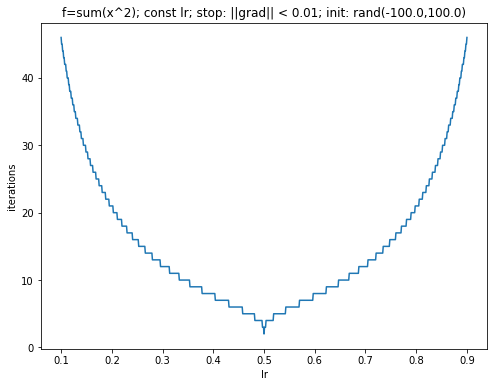

fastest convergence( 2 iterations) with lr = 0.5


In [ ]:
plot_iters(0.1, 0.9, 0.001, lambda st: gradient_descent(f_square_sum, EPS_GRAD, 
                                                       const_step_updater(),
                                                       rand_range_init_func(INIT_RAND_RANGE),
                                                       dims=10, step=st)[3],
           "lr", f'f=sum(x^2); const lr; stop: ||grad|| < {EPS_GRAD};' + 
           f' init: rand(-{INIT_RAND_RANGE},{INIT_RAND_RANGE})');

Вывод: сходимость достигается медленнее как при слишком маленьком шаге, так и при слишком большом (градиент уходит дальше минимума)

# Часть 2

  0%|          | 0/501 [00:00<?, ?it/s]

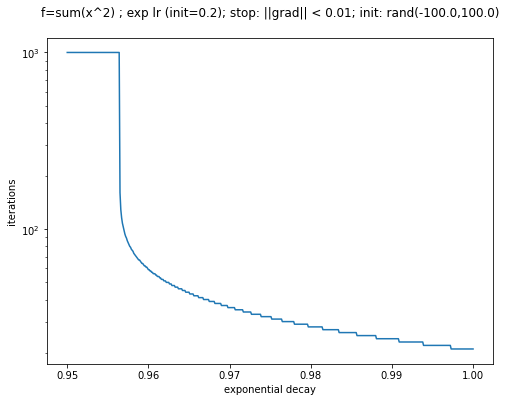

fastest convergence( 21 iterations) with exponential decay = 0.9973


In [ ]:
best_exp_decay, _ = plot_iters(0.95, 1.0, 0.0001, lambda dec: 
                               gradient_descent(f_square_sum, EPS_GRAD, 
                                                exp_step_updater(dec),
                                                rand_range_init_func(INIT_RAND_RANGE),
                                                dims=10, step=INIT_LR)[3],
           "exponential decay",
           f'f=sum(x^2) ; exp lr (init={INIT_LR}); stop: ||grad|| < {EPS_GRAD};'+ 
           f' init: rand(-{INIT_RAND_RANGE},{INIT_RAND_RANGE})\n',
           logged=True)

Вывод: при слишком большом затухании шага градиентный спуск не успевает дойти до минимума (при ограничении в 1000 итераций). Далее скорость сходимости с возрастанием коэффициента затухания экспоненциально растет. При коэффициенте=1 функция изменения шага эквивалена константной.

  0%|          | 0/491 [00:00<?, ?it/s]

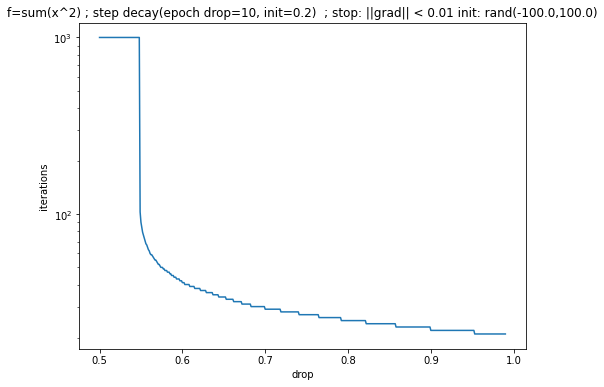

fastest convergence( 21 iterations) with drop = 0.953


In [ ]:
epoch_drop = 10
best_drop, _ = plot_iters(0.5, 0.99, 0.001, lambda dr: gradient_descent(f_square_sum, EPS_GRAD,
                                                      step_decay_updater(dr, epoch_drop),
                                                      rand_range_init_func(INIT_RAND_RANGE),
                                                      dims=10, step=INIT_LR)[3],
           "drop", f'f=sum(x^2) ; step decay(epoch drop={epoch_drop}, init={INIT_LR}) '
           + f' ; stop: ||grad|| < {EPS_GRAD}'
           + f' init: rand(-{INIT_RAND_RANGE},{INIT_RAND_RANGE})',
           logged=True)

Вывод: при фиксированном epoch drop зависимость аналогична функции с экспоненциальным затуханием.

  0%|          | 0/92 [00:00<?, ?it/s]

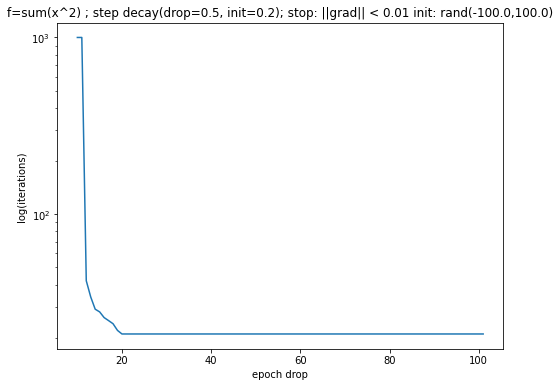

fastest convergence( 21 iterations) with epoch drop = 20


In [ ]:
drop=0.5
best_epoch_drop, _ = plot_iters(10, 101, 1, lambda ep_dr: gradient_descent(f_square_sum, EPS_GRAD,
                                                      step_decay_updater(drop, ep_dr),
                                                      rand_range_init_func(INIT_RAND_RANGE),
                                                      dims=10, step=INIT_LR)[3],
           "epoch drop", f'f=sum(x^2) ; step decay(drop={drop}, init={INIT_LR}); '
           + f'stop: ||grad|| < {EPS_GRAD}'
           + f' init: rand(-{INIT_RAND_RANGE},{INIT_RAND_RANGE})',
           logged=True)

Вывод: При фикс кооэфф затухания = 0.5 начиная с epoch drop = 21 сходимость достигается раньше, чем происходит затухание шага.

# Часть 3

In [ ]:
def add_stats(func, func_title, step_updater, step_updater_title , rand_range, 
              dims, step, res, y_target, max_iters=1000):
    _, y, _, iters, f_calls = gradient_descent(func, EPS_GRAD, 
                                               step_updater,
                                               rand_range_init_func(rand_range),
                                               max_iters = max_iters,
                                               dims=dims, step=step)
    res.append([func_title,
               step_updater_title,
               step,
               f'U(-{rand_range}, +{rand_range})',
               dims,
               iters, 
               f_calls, 
               abs(y_target-y)])

In [ ]:
res = []
add_stats(f_square_sum, "sum(x^2)", const_step_updater(), "const lr",
          INIT_RAND_RANGE, 10, STANDARD_LR, res, 0)

add_stats(f_square_sum, "sum(x^2)", exp_step_updater(round(best_exp_decay, 3)),
          f'exponential decay({round(best_exp_decay, 3)})',
          INIT_RAND_RANGE, 10, INIT_LR, res, 0)
drop, epoch_drop = best_drop, 10
add_stats(f_square_sum, "sum(x^2)", step_decay_updater(drop, epoch_drop), 
          f'step decay(drop={drop}, epoch_drop={epoch_drop})',
          INIT_RAND_RANGE, 10, INIT_LR, res, 0)
add_stats(f_square_sum, "sum(x^2)", golden_step_updater(0, 1), "golden ratio",
          INIT_RAND_RANGE, 10, None, res, 0)

In [ ]:
add_stats(rosenbrock(), "rosenbrock", const_step_updater(), "const lr",
          1.0, 2, 1e-3, res, 0, 100000)
exp_decay = 0.995
add_stats(rosenbrock(), "rosenbrock", exp_step_updater(exp_decay),
          f'exponential decay({exp_decay})',
          1.0, 2, 2e-3, res, 0, 100000)
drop, epoch_drop = 0.95, 10
add_stats(rosenbrock(), "rosenbrock", step_decay_updater(drop, epoch_drop), 
          f'step decay(drop={drop}, epoch_drop={epoch_drop})',
          1.0, 2, 2e-3, res, 0, 100000)
add_stats(rosenbrock(), "rosenbrock", golden_step_updater(0, 1), "golden ratio",
          1.0, 2, 2e-3, res, 0)

results_df = pd.DataFrame(res, columns=["function", "lr scheduling","init lr", 
                                   "init x", "dim", "iterations", 
                                   "function calls", "error"])

results_df

,function,lr scheduling,init lr,init x,dim,iterations,function calls,error
0,sum(x^2),const lr,0.100,"U(-100.0, +100.0)",10,46,0,0.000055
1,sum(x^2),exponential decay(0.997),0.200,"U(-100.0, +100.0)",10,22,0,0.000034
2,sum(x^2),"step decay(drop=0.9530000000000001, epoch_drop...",0.200,"U(-100.0, +100.0)",10,21,0,0.000081
3,sum(x^2),golden ratio,NaN,"U(-100.0, +100.0)",10,3,36,0.000019
4,rosenbrock,const lr,0.001,"U(-1.0, +1.0)",2,6757,0,0.000154
5,rosenbrock,exponential decay(0.995),0.002,"U(-1.0, +1.0)",2,100000,0,0.051782
6,rosenbrock,"step decay(drop=0.95, epoch_drop=10)",0.002,"U(-1.0, +1.0)",2,100000,0,0.051921
7,rosenbrock,golden ratio,0.002,"U(-1.0, +1.0)",2,12,144,NaN


Вывод: Для квадратичной функции метод золотого сечения дает самую быструю сходимость, но при этом требует дополнительных вычислений функций. Для функции Розенброка сходимость достиглась только при константном шаге (при ограничении в 100000 итераций), а метод золотого сечения сошелся не к глобальному минимуму. 

# Часть 5

In [ ]:
def plotTrace(trace):
    x_values, y_values = zip(*trace)
    plt.plot(x_values, y_values, '-o', linewidth=1.0, ms=5.0,
             alpha=1.0, label="Trajectory", color='0.0')

In [ ]:
def plotLevels(func, xrange, yrange, levels):
    x = np.linspace(xrange[0], xrange[1], 100)
    y = np.linspace(yrange[0], yrange[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = float(func(torch.Tensor([X[i, j], Y[i, j]]).double()))

    map_n = 100
    # my_cmap = ListedColormap(np.stack([np.ones(map_n), 
    #                                    np.ones(map_n),
    #                                    np.linspace(220, 80, map_n) / 255.]).T)
    my_cmap = plt.cm.Blues

    plt.figure(figsize=(10, 10))
    _ = plt.contourf(X, Y, Z, levels=levels, cmap=my_cmap)
    CS = plt.contour(X, Y, Z, levels=levels, colors='0.8')
    plt.clabel(CS, inline=1, fontsize=8, colors='0.4')
    plt.grid()

In [ ]:
def process_f(func, step_updater, levels, title, 
              init_f= rand_range_init_func(1.0), 
              dims=2):
    _, _, xs, _, _ = gradient_descent(func, EPS_GRAD, step_updater, init_f, 
                                      dims=dims)

    plotLevels(func, 
               [xs[:, 0].min() - 0.3, xs[:, 0].max() + 0.3], 
               [xs[:, 1].min() - 0.3, xs[:, 1].max() + 0.3], 
               levels)
    
    plotTrace(xs)
    plt.legend()
    plt.title(title)
    plt.show()

## $z=x^2+xy+3y^2+x-y$

In [ ]:
def square_f(xs):
    A = torch.tensor([[1.0, -1.0], [2.0, 3.0]], dtype=torch.float64)
    B = torch.tensor([1.0, -1.0], dtype=torch.float64)
    return torch.dot(torch.matmul(A, xs), xs) + torch.dot(xs, B)

square_f_levels = [-0.5, -0.4, -0.2, 0.0, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]
square_f_levels_lg = [10., 50., 100.0, 150.0, 200., 300., 
                      1000.0, 3000., 5000., 10000.]

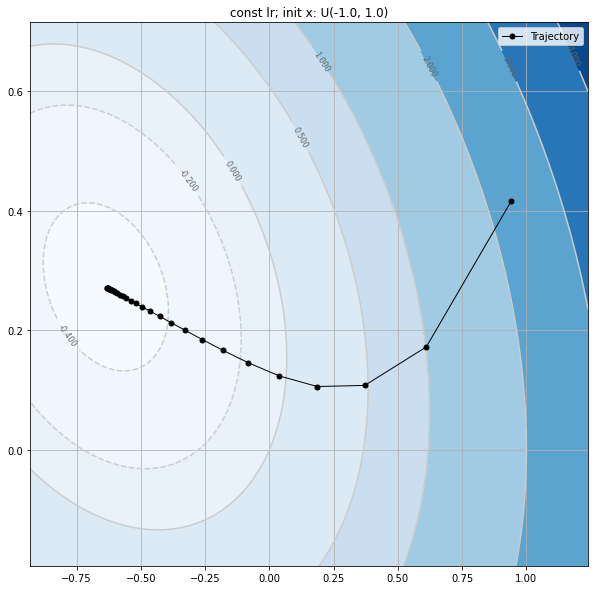

In [ ]:
process_f(square_f, const_step_updater(), 
          square_f_levels, "const lr; init x: U(-1.0, 1.0)")

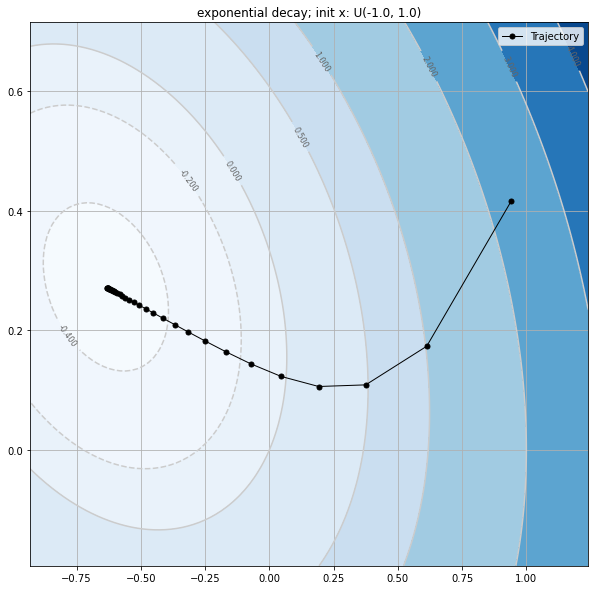

In [ ]:
process_f(square_f, exp_step_updater(0.995), square_f_levels,
          "exponential decay; init x: U(-1.0, 1.0)")

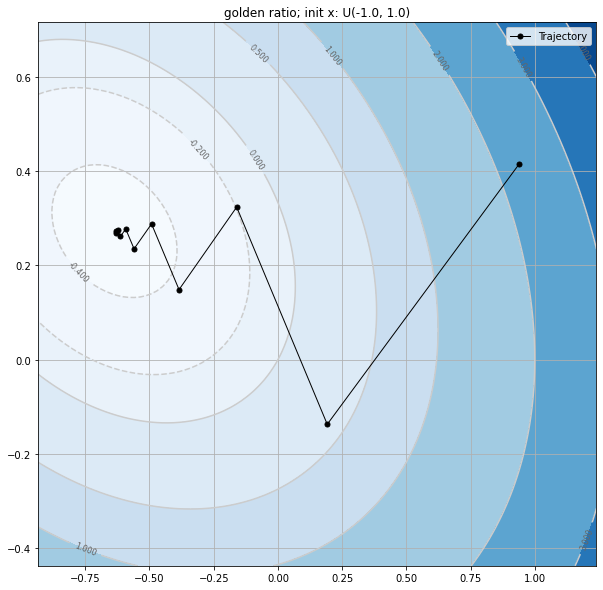

In [ ]:
process_f(square_f, golden_step_updater(0, 1), square_f_levels,
          "golden ratio; init x: U(-1.0, 1.0)")

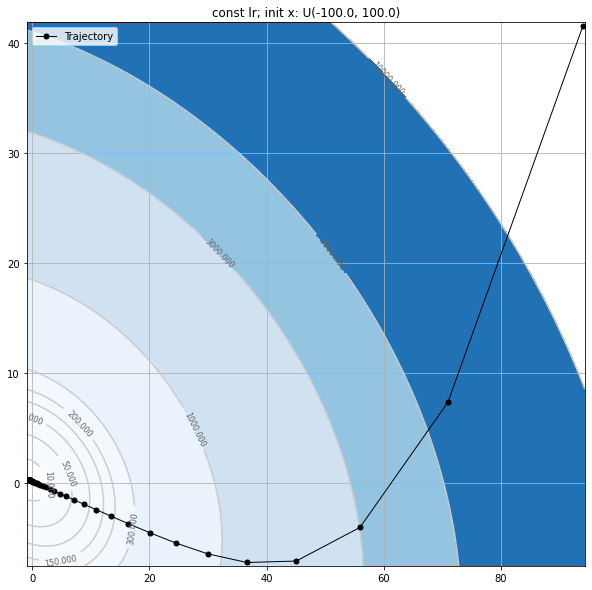

In [ ]:
process_f(square_f, const_step_updater(), square_f_levels_lg,
          f'const lr; init x: U(-{INIT_RAND_RANGE}, {INIT_RAND_RANGE})',
          rand_range_init_func(INIT_RAND_RANGE))

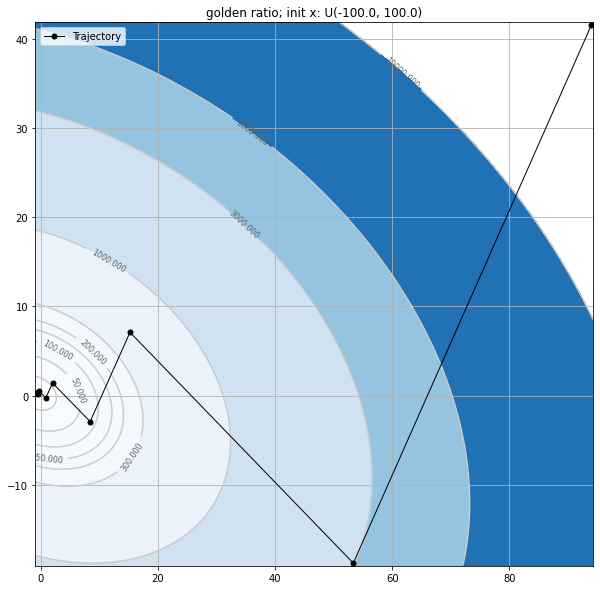

In [ ]:
process_f(square_f, golden_step_updater(0, 1),
          square_f_levels_lg,
          f'golden ratio; init x: U(-{INIT_RAND_RANGE}, {INIT_RAND_RANGE})',
          rand_range_init_func(INIT_RAND_RANGE))

##  $z=3x^2-4xy+2y^2-x+2y$

In [ ]:
def square_f2(xs):
    A = torch.tensor([[3.0, -2.0], [-2.0, 2.0]], dtype=torch.float64)
    B = torch.tensor([-1.0, 2.0], dtype=torch.float64)
    return torch.dot(torch.matmul(A, xs), xs) + torch.dot(xs, B)

square_f2_levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 1.0, 1.5, 2.0]
square_f2_levels_lg = [10.0, 50., 150., 500., 1000., 5000., 10000.]

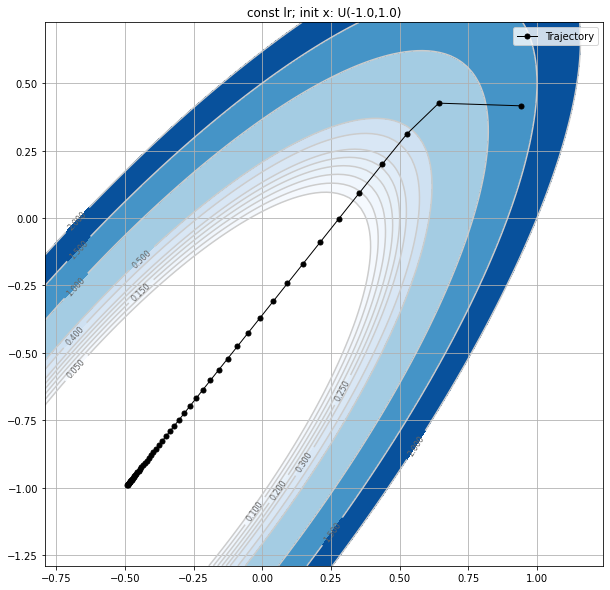

In [ ]:
process_f(square_f2, const_step_updater(), square_f2_levels,
          'const lr; init x: U(-1.0,1.0)')

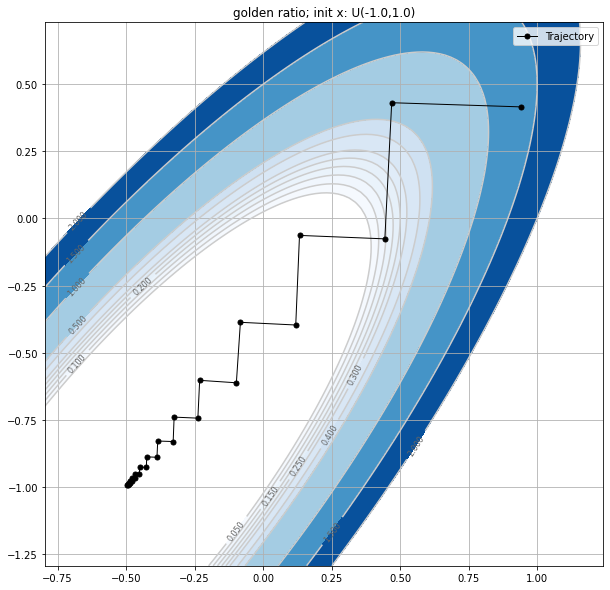

In [ ]:
process_f(square_f2, golden_step_updater(0, 1), square_f2_levels,
          'golden ratio; init x: U(-1.0,1.0)')

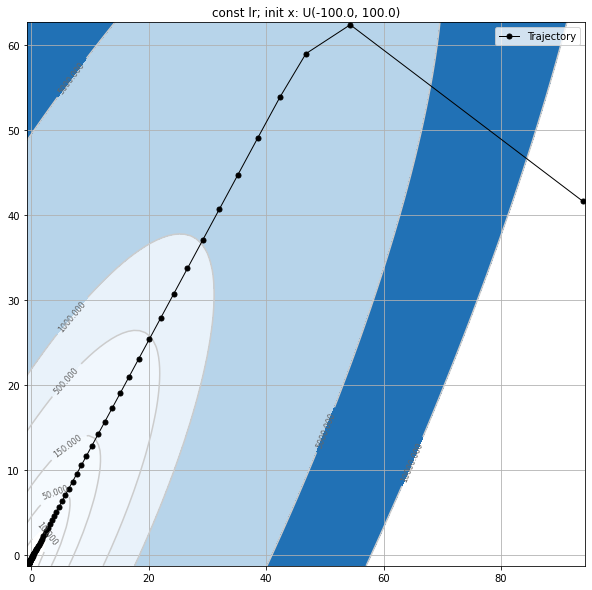

In [ ]:
process_f(square_f2, const_step_updater(), square_f2_levels_lg, 
          f'const lr; init x: U(-{INIT_RAND_RANGE}, {INIT_RAND_RANGE})',
          rand_range_init_func(INIT_RAND_RANGE))

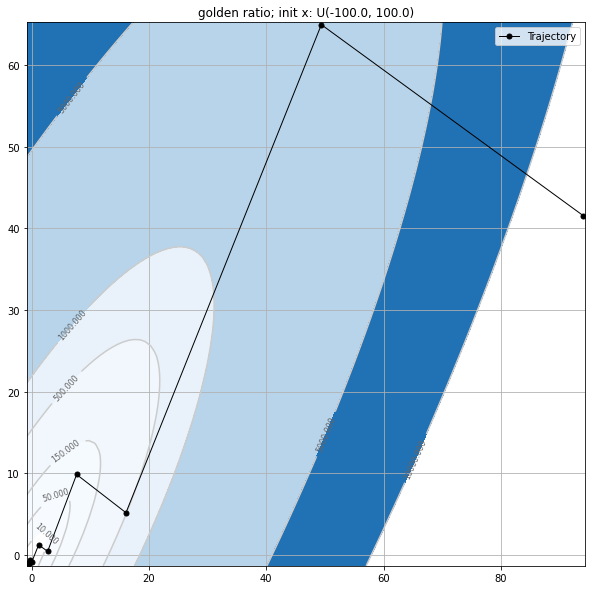

In [ ]:
process_f(square_f2, golden_step_updater(0, 1), square_f2_levels_lg, 
          f'golden ratio; init x: U(-{INIT_RAND_RANGE}, {INIT_RAND_RANGE})',
          rand_range_init_func(INIT_RAND_RANGE))

Вывод: при константном шаге или экспоненциальном затухании траектория движения к минимуму "плавная", а при использовании метода золотого сечения траектория выглядит как "зиг-заг".

# Часть 6

In [ ]:
def gen_random_f(n):
    np.random.seed(0)
    B = torch.tensor(np.random.uniform(low=-10.0, high=10.0, size=(n,n)), 
              dtype=torch.float64)
    Q = torch.matmul(B, B.T)
    c = torch.tensor(np.random.uniform(low=-10.0, high=10.0, size=n), 
                dtype=torch.float64)
    return lambda xs: torch.dot(torch.matmul(Q, xs), xs) + torch.dot(xs, c)

  0%|          | 0/32 [00:00<?, ?it/s]

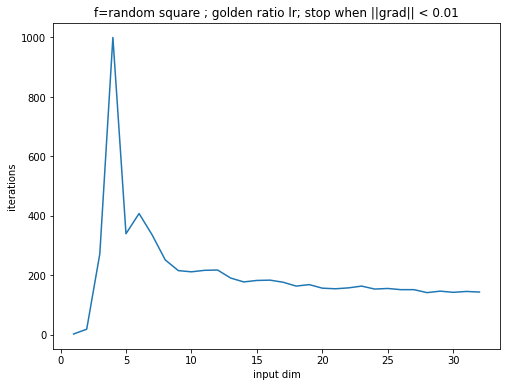

fastest convergence( 3 iterations) with input dim = 1


(1, 3)

In [ ]:
plot_iters(1, 32, 1, lambda n: gradient_descent(gen_random_f(n), 1e-2,
                                                 golden_step_updater(0, 1),
                                                 rand_range_init_func(INIT_RAND_RANGE),
                                                 dims=n)[3],
           "input dim", "f=random square ; golden ratio lr; stop when ||grad|| < " 
           + str(1e-2))

  0%|          | 0/32 [00:00<?, ?it/s]

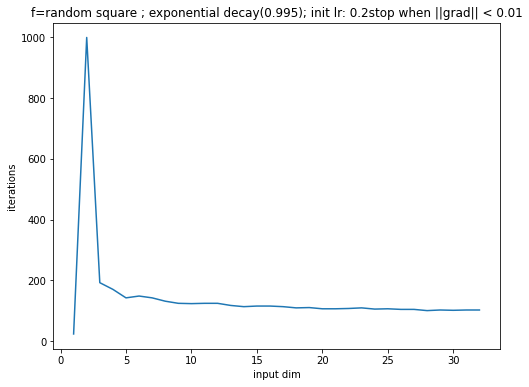

fastest convergence( 23 iterations) with input dim = 1


(1, 23)

In [ ]:
exp_decay = 0.995
plot_iters(1, 32, 1, lambda n: gradient_descent(gen_random_f(n), 1e-2,
                                                 exp_step_updater(exp_decay),
                                                 rand_range_init_func(INIT_RAND_RANGE),
                                                 dims=n, step=INIT_LR)[3],
           "input dim", 
           f'f=random square ; exponential decay({exp_decay}); '+
           f'init lr: {INIT_LR}' +
           f'stop when ||grad|| < {1e-2}')

Вывод: начиная с определенного момента с ростом размерности число итераций не увеличивается